In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
import xml.etree.ElementTree as et
import pandas as pd
import math

pathOfImages = 'C:/Users/hp/Jupyter Notebook Work/Practicum - Face Mask Detection/Dataset/images'
pathOfAnnotations = 'C:/Users/hp/Jupyter Notebook Work/Practicum - Face Mask Detection/Dataset/annotations'

In [2]:
image_path= pathlib.Path(pathOfImages)
annot_path = pathlib.Path(pathOfAnnotations)

In [3]:
# Database Stats - Using Annotations
# Mask wise Stats - Using Annotations

def database_stats():
    face_count = []
    label_dict = {'with_mask': 0, 'without_mask': 0, 'mask_weared_incorrect': 0}
    
    for file in os.listdir(annot_path):
        root = (et.parse(os.path.join(annot_path, file))).getroot()
        face_count.append(len(root) - 4)
        for i in range(4,len(root)):
            label_dict[root[i][0].text] += 1

    print("Number of Pictures: ", len(os.listdir(annot_path)))
    print("Maximum Faces per Picture: ", max(face_count))
    print("Average Faces per Picture: ", round(np.mean(face_count),1))
    
    print('')
    print('Mask wise Stats:')
    print("Faces with mask: ", label_dict['with_mask'])
    print("Faces without mask: ", label_dict['without_mask'])
    print("Faces with mask worn incorrectly: ", label_dict['mask_weared_incorrect'])

In [4]:
# Creating a readable dataframe from the database

def create_dataframe():
    image_dict = {"image": [],"Dimensions": [], "face_count": []}
    
    for i in range(1,116):
        image_dict[f'Object {i}']=[]

    for file in sorted(os.listdir(annot_path)):
        row = []
        root = (et.parse(os.path.join(annot_path, file))).getroot()
        
        img = root[1].text # image name
        row.append(img)
        
        h,w = root[2][0].text,root[2][1].text # image dimensions
        row.append([h,w])
        
        face_ct = len(root) - 4 # face count
        row.append(face_ct)

        for i in range(4,len(root)): # add column to each row for each face
            temp = []
            temp.append(root[i][0].text) # object label
            
            coordinate_counter = 0
            for point in root[i][5]: # bounding box dimensions - Increase by certain percentage
                coordinate_counter = coordinate_counter + 1
                if coordinate_counter == 1:
                    point.text = str(math.ceil(int(point.text) - (0.03 * int(point.text))))
                elif coordinate_counter == 2:
                    point.text = str(math.ceil(int(point.text) - (0.05 * int(point.text))))
                elif coordinate_counter == 3:
                    point.text = str(math.ceil(int(point.text) + (0.03 * int(point.text))))
                elif coordinate_counter == 4:
                    point.text = str(math.ceil(int(point.text) + (0.01 * int(point.text))))

                temp.append(point.text)
                
            row.append(temp)
        
        for i in range(len(row),119): # add a 0 for rest
            row.append(0)

        
        for i,each in enumerate(image_dict): # Dictionarize
            image_dict[each].append(row[i])
            
    print('')
    print('DataFrame:')
            
    return pd.DataFrame(image_dict)
    
    
# reference: https://docs.python.org/3/library/xml.etree.elementtree.html

In [5]:
# adds annotation labels and bounding boxes to each image so that we can display ground truth images with annotations

def show_annotated_image(image):
    
    row = dataframe[dataframe['image'] == image]
    idx = row.index
    
    new_image_path = os.path.join(image_path,image)
    
    original_image = cv2.imread(new_image_path)
    
    for obj in row.columns[3:]:
        info = row[obj][idx]
        if info.any():
            label_name = info.iloc[0][0]
            coordinates = info.iloc[0][1:]

            if label_name == 'with_mask':
                label = 'Masked'
                color = (0, 255, 0)
            elif label_name == 'without_mask':
                label = 'No Mask'
                color = (0, 0, 255)
            else:
                label = 'Incorrect Mask'
                color = (255, 0, 0)
            
            coordinates = [int(pt) for pt in coordinates]

            cv2.rectangle(
                original_image,
                (coordinates[0], coordinates[1]),
                (coordinates[2], coordinates[3]),
                color,
                2
            )
            
            cv2.putText(original_image, label, (coordinates[0], coordinates[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    
    print('')
    print('Annotated Image:')
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)) 

In [6]:
# Plot Original Image from Databse

def show_original_image(image):
    test_image_path = os.path.join(image_path, image)
    test_image = cv2.imread(test_image_path)
    
    print('')
    print('Original Image:')
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

In [7]:
database_stats()
dataframe = create_dataframe()
dataframe.head()

Number of Pictures:  853
Maximum Faces per Picture:  115
Average Faces per Picture:  4.8

Mask wise Stats:
Faces with mask:  3232
Faces without mask:  717
Faces with mask worn incorrectly:  123

DataFrame:


,image,Dimensions,face_count,Object 1,Object 2,Object 3,Object 4,Object 5,Object 6,Object 7,...,Object 106,Object 107,Object 108,Object 109,Object 110,Object 111,Object 112,Object 113,Object 114,Object 115
0,maksssksksss0.png,"[512, 366]",3,"[without_mask, 77, 100, 113, 144]","[with_mask, 180, 95, 233, 146]","[without_mask, 316, 86, 371, 143]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,maksssksksss1.png,"[400, 156]",9,"[with_mask, 312, 33, 365, 70]","[with_mask, 218, 37, 269, 74]","[with_mask, 291, 56, 325, 82]","[with_mask, 139, 71, 180, 117]","[with_mask, 72, 66, 98, 100]","[with_mask, 186, 64, 228, 94]","[with_mask, 21, 70, 46, 94]",...,0,0,0,0,0,0,0,0,0,0
2,maksssksksss10.png,"[301, 400]",1,"[with_mask, 96, 254, 200, 387]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,maksssksksss100.png,"[400, 226]",3,"[with_mask, 184, 29, 253, 89]","[with_mask, 376, 52, 412, 76]","[with_mask, 115, 83, 168, 128]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,maksssksksss101.png,"[301, 400]",1,"[with_mask, 47, 280, 169, 404]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Original Image:


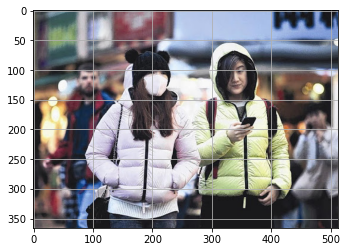

In [9]:
show_original_image('maksssksksss0.png')
plt.grid(None)


Annotated Image:


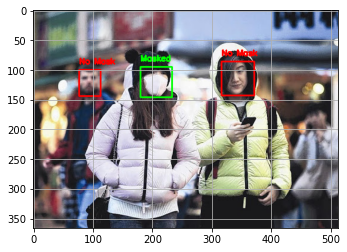

In [10]:
show_annotated_image('maksssksksss0.png')
plt.grid(None)

In [11]:
# pickle the image dataframe for future reference

dataframe.to_pickle('1.2.increased_bounding_box_annotated_image_dataframe.pkl')